In [1]:
import numpy as np
from matplotlib import pyplot as plt
from evtools.sim_tools.process_evcdr_multiple import ProcessEVCDRMultiple

evcdr = ProcessEVCDRMultiple(folder_index=1, backend='ibm_sherbrooke', batches=[1,2,3])
evcdr.n_resamples = 50_000
evcdr.use_old_regression = True
evcdr.normalize_clifford_purity = False
evcdr.get_results(
    neighbourhood_list=[4,4,4,4,3,0,3,0,3,3],
    hamming_list      =[0,0,0,3,4,5,5,5,4,4]
)

----------------------------
| Processing step number 1 |
----------------------------
>> loaded qpu job at step=1, batch=1
	>> retrieved measurement data
	>> extracted noisy expectation values
>> loaded qpu job at step=1, batch=2
	>> retrieved measurement data
	>> extracted noisy expectation values
>> loaded qpu job at step=1, batch=3
	>> retrieved measurement data
	>> extracted noisy expectation values
----------------------------
| Processing step number 2 |
----------------------------
>> loaded qpu job at step=2, batch=1
	>> retrieved measurement data
	>> extracted noisy expectation values
>> loaded qpu job at step=2, batch=2
	>> retrieved measurement data
	>> extracted noisy expectation values
>> loaded qpu job at step=2, batch=3
	>> retrieved measurement data
	>> extracted noisy expectation values
----------------------------
| Processing step number 3 |
----------------------------
>> loaded qpu job at step=3, batch=1
	>> retrieved measurement data
	>> extracted noisy expectati

In [2]:
def average_without_outliers(arr,stdin,n_devs=30):
    std = np.std(arr, axis=1)
    avg = np.mean(arr, axis=1)
    mask_outliers = abs(arr - avg.reshape(-1,1)) < n_devs*std.reshape(-1,1)+1e-10
    avgout = []
    stdout = []
    for row,rowstd,mask in zip(arr,stdin,mask_outliers):
        avgout.append(np.mean(row[mask]))
        stdout.append(np.mean(rowstd[mask]))
    return np.array(avgout),np.array(stdout)

score_num_devs_list   = [None, None, None, None, None, 3, 6.2, None, None, None]
outlier_num_devs_list = [None, None, None, None, None, 3, 1.2, None, None, None]
stddev_num_devs_list  = [None, None, None, None, None, 3, 3.3, None, None, None]
order = ['','','','','_Z_only','_Z_only','_Z_only','_Z_only','_Z_only','_Z_only']

clifford_interpolated,clifford_std=[],[]
clifford_masks = []
for which,step,score_num_devs,outlier_num_devs,stddev_num_devs in zip(order,evcdr.steps,score_num_devs_list,outlier_num_devs_list,stddev_num_devs_list):
    step = str(step)
    n_points = evcdr.results['clifford_data']['Z']['noisy'][step][0].shape[0]
    curves_Z = evcdr.results['clifford_data']['Z']['curve'][step]
    curves_X = evcdr.results['clifford_data']['X']['curve'][step]
    X_sosr = evcdr.results['clifford_data']['X']['sosr'][step]
    Z_sosr = evcdr.results['clifford_data']['Z']['sosr'][step]
    cliff_res,cliff_std = evcdr.results['expvals'][f'clifford_interpolated{which}'][step]
    if score_num_devs is not None:
        clifford_mask = (
            (X_sosr <= np.min(X_sosr)+score_num_devs*np.std(X_sosr)) & 
            (Z_sosr <= np.min(Z_sosr)+score_num_devs*np.std(Z_sosr)) &
            (cliff_std <= cliff_std.min() + stddev_num_devs*cliff_std.std())
        )
    elif stddev_num_devs is not None:
        clifford_mask = (cliff_std <= cliff_std.min() + stddev_num_devs*cliff_std.std())
    else:
        clifford_mask = np.ones_like(cliff_res, dtype=bool)
    if outlier_num_devs is None:
        outlier_num_devs = 30

    clifford_masks.append(clifford_mask)
    cliff_masked = np.array(cliff_res[clifford_mask]).reshape(1,-1)
    stdev_masked = np.array(cliff_std[clifford_mask]).reshape(1,-1)
    avg, std = average_without_outliers(cliff_masked,stdev_masked,n_devs=outlier_num_devs)
    avg,std=avg[0],std[0]
    clifford_interpolated.append(avg)
    clifford_std.append(std)
clifford_interpolated = np.array(clifford_interpolated)
clifford_std = np.array(clifford_std)
clifford_masks = np.vstack(clifford_masks)

Text(0.5, 0, 'Time $t$')

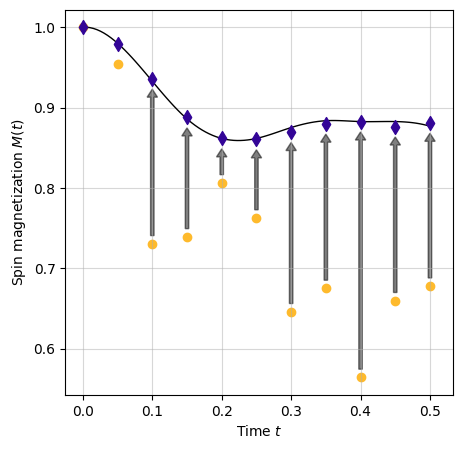

In [3]:
_times = np.array(evcdr.results['times'])
raw_energies,raw_std = average_without_outliers(*zip(*evcdr.results['expvals']['raw'].values()))
fig, axis = plt.subplots(figsize=(5,5))

raw_errors = np.append(1,raw_energies)
evcdr_errors = np.append(1,clifford_interpolated)

for t,re,ee, in zip(np.append(0,_times),raw_errors,evcdr_errors):
    if t>0.05:
        axis.arrow(t,re+0.01,0,(ee-re)-0.023,width=0.005, alpha=0.5,
            length_includes_head=True,head_width=0.015,color='black',head_length=0.01
        )

with open('data/EVCDR/1/TNS_10_steps.json', 'r') as infile:
    import json
    data_in = json.load(infile)
    times = data_in['times']
    exact_evo = data_in['energy']

from scipy.interpolate import CubicSpline # smooth out the noiseless curve
evo_interp_func      = CubicSpline(times, exact_evo)
clifford_interp_func = CubicSpline(np.append(0,_times), np.append(1,clifford_interpolated))
raw_interp_func      = CubicSpline(np.append(0,_times), np.append(1,raw_energies))

plasma0=plt.cm.plasma_r(0.15)
plasma3=plt.cm.plasma_r(.93)
times = np.linspace(0,0.5,100)
axis.plot(times, evo_interp_func(times), color='black', label='Exact', lw=1)
times = times[10:]
axis.scatter(np.append(0,_times), raw_errors, marker='o', color=plasma0)
axis.scatter(np.append(0,_times), evcdr_errors, marker='d', color=plasma3, zorder=10, s=50)
axis.grid(alpha=0.5)
axis.set_ylabel('Spin magnetization $M(t)$')
axis.set_xlabel('Time $t$')
# fig.savefig('plots/evcdr_example_plot.pdf', dpi=300, bbox_inches='tight', transparent=True)

Text(0.5, 91.7222222222222, 'Time $t$')

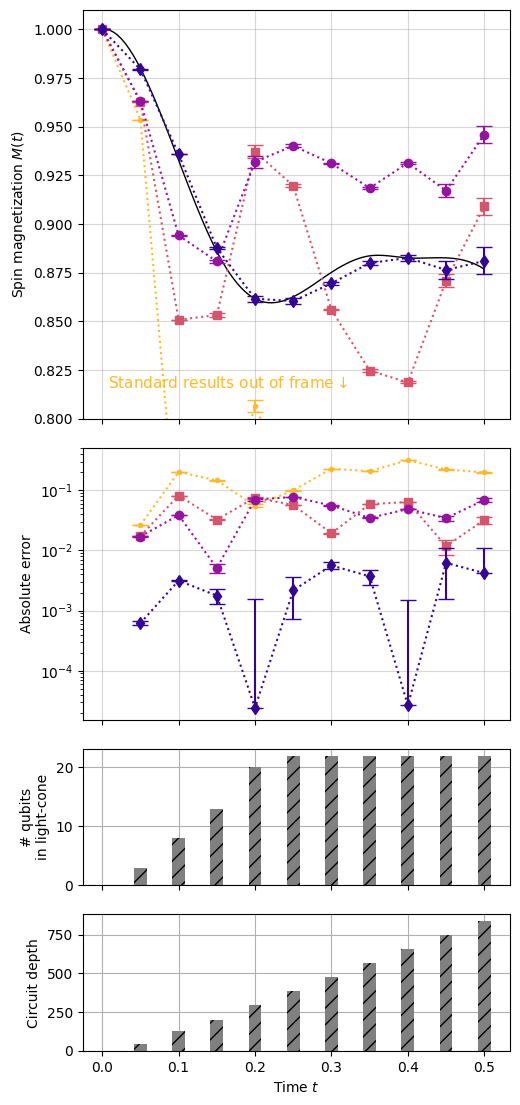

In [4]:
plt.rc('axes', axisbelow=True)
_times = np.array(evcdr.results['times'])
raw_energies,raw_std = average_without_outliers(*zip(*evcdr.results['expvals']['raw'].values()))
density_purified,density_std = average_without_outliers(*zip(*evcdr.results['expvals']['density_purified'].values()))
purity_normalized,purity_std =average_without_outliers(*zip(*evcdr.results['expvals']['purity_normalized'].values()))
circuit_depths = list(evcdr.results['circuit_depths'].values())

with open('data/EVCDR/1/TNS_10_steps.json', 'r') as infile:
    import json
    data_in = json.load(infile)
    noiseless_energies = data_in['energy'][1:]
with open('data/EVCDR/1/exact_evolution_21_q.json', 'r') as infile:
    import json
    exact_sim_data = json.load(infile)
    exact_sim_times = np.asarray(exact_sim_data['times'])
    exact_sim_steps = np.asarray(exact_sim_data['steps'])
    exact_sim_vals = np.asarray(exact_sim_data['vals'])    

noiseless_energies = evo_interp_func(_times)
noiseless_energies[:exact_sim_vals.shape[0]-1] = exact_sim_vals[1:]

fig, axes = plt.subplots(4,1,figsize=(5,11), gridspec_kw={'height_ratios':[3,2,1,1]}, sharex=True)
fig.tight_layout()
times = np.linspace(0,0.5,100)
evo_interp_func = CubicSpline(np.append(0,_times), np.append(1,noiseless_energies))

plasma0=plt.cm.plasma_r(0.15)
plasma1=plt.cm.plasma_r(.45)
plasma2=plt.cm.plasma_r(.68)
plasma3=plt.cm.plasma_r(.93)

axes[0].plot(times, evo_interp_func(times), color='black', label='Noiseless', ls='-', lw=1)
eb1=axes[0].errorbar(np.append(0,_times), np.append(1,raw_energies), yerr=np.append(0,raw_std), label='EV (standard)', marker='.', capsize=6, ls=':', color=plasma0, zorder=1)
eb2=axes[0].errorbar(np.append(0,_times), np.append(1, density_purified), yerr=np.append(0,density_std), label='EV (spectral purification)', marker='o', capsize=6, ls=':', color=plasma2, zorder=7)
eb3=axes[0].errorbar(np.append(0,_times), np.append(1, purity_normalized), yerr=np.append(0,purity_std), label='EV (purity normalization)', marker='s', capsize=6, ls=':', color=plasma1, zorder=4)
eb4=axes[0].errorbar(np.append(0,_times), np.append(1, clifford_interpolated), yerr=np.append(0,clifford_std), label='EVCDR', marker='d', capsize=6, ls=':', color=plasma3, zorder=10)

clifford_dev = np.tile(clifford_std, (2,1)); clifford_dev[0,abs(clifford_interpolated-noiseless_energies)-clifford_std<0] = 0
eb4=axes[1].errorbar(_times, abs(clifford_interpolated-noiseless_energies), yerr=clifford_dev, marker='d', capsize=6, ls=':', color=plasma3, zorder=10)
raw_dev = np.tile(raw_std, (2,1)); raw_dev[0,abs(raw_energies-noiseless_energies)-raw_std<0] = 0
eb1=axes[1].errorbar(_times, abs(raw_energies-noiseless_energies), yerr=raw_dev, marker='.', capsize=6, ls=':', color=plasma0, zorder=1)
density_dev = np.tile(density_std, (2,1)); density_dev[0,abs(density_purified-noiseless_energies)-density_std<0] = 0
eb2=axes[1].errorbar(_times, abs(density_purified-noiseless_energies), yerr=density_dev, marker='o', capsize=6, ls=':', color=plasma2, zorder=7)
purity_dev = np.tile(purity_std, (2,1)); purity_dev[0,abs(purity_normalized-noiseless_energies)-purity_std<0] = 0
eb3=axes[1].errorbar(_times, abs(purity_normalized-noiseless_energies), yerr=purity_dev, marker='s', capsize=6, ls=':', color=plasma1, zorder=4)

axes[2].bar(_times, [len(qs)/4 for qs in evcdr.results['active_qubits'].values()], width=evcdr.step_size/6, color='grey', hatch='//', alpha=1)
axes[2].set_ylabel('# qubits\nin light-cone')
axes[2].grid()
axes[3].bar(_times, circuit_depths, width=evcdr.step_size/6, color='grey', hatch='//', alpha=1)
axes[3].set_ylabel('Circuit depth')
axes[3].grid()
axes[0].grid(alpha=0.5)
axes[1].grid(alpha=0.5)
axes[1].set_yscale('log')
axes[0].set_ylim([0.8,1.01])
axes[0].text(0.008,0.816,'Standard results out of frame$\\downarrow$', color=plasma0, fontsize=11)
axes[0].set_ylabel('Spin magnetization $M(t)$')
axes[1].set_ylabel('Absolute error')
axes[3].set_xlabel('Time $t$')
# axes[0].legend(ncol=3, loc='lower left', bbox_to_anchor=(-0.17,-1.81))

# fig.savefig('plots/21_qubit_spin_evolution.pdf', dpi=300, bbox_inches='tight', transparent=True)

[0.         0.02244898 0.04489796 0.06734694 0.08979592 0.1122449
 0.13469388 0.15714286 0.17959184 0.20204082 0.2244898  0.24693878
 0.26938776 0.29183673 0.31428571 0.33673469 0.35918367 0.38163265
 0.40408163 0.42653061 0.44897959 0.47142857 0.49387755 0.51632653
 0.53877551 0.56122449 0.58367347 0.60612245 0.62857143 0.65102041
 0.67346939 0.69591837 0.71836735 0.74081633 0.76326531 0.78571429
 0.80816327 0.83061224 0.85306122 0.8755102  0.89795918 0.92040816
 0.94285714 0.96530612 0.9877551  1.01020408 1.03265306 1.05510204
 1.07755102 1.1       ]


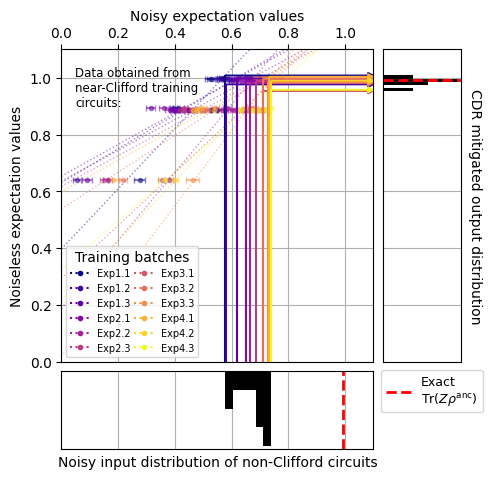

In [5]:
index = 5
mask = np.ones_like(clifford_masks[index], dtype=bool)
# mask = clifford_masks[index]
step = str(index+1)

X_noisy = evcdr.results['clifford_data']['X']['noisy'][step][:,mask]
Z_noisy = evcdr.results['clifford_data']['Z']['noisy'][step][:,mask]
X_stdev = evcdr.results['clifford_data']['X']['stdev'][step][:,mask]
Z_stdev = evcdr.results['clifford_data']['Z']['stdev'][step][:,mask]
X_ideal = evcdr.results['clifford_data']['X']['ideal'][step]
Z_ideal = evcdr.results['clifford_data']['Z']['ideal'][step]
X_curve = evcdr.results['clifford_data']['X']['curve'][step]
Z_curve = evcdr.results['clifford_data']['Z']['curve'][step]
X_curve = [X_curve[i] for i in np.where(mask)[0]]
Z_curve = [Z_curve[i] for i in np.where(mask)[0]]

X_standard = evcdr.results['standard_data']['X']['expval'][step][mask]
Z_standard = evcdr.results['standard_data']['Z']['expval'][step][mask]

V = evo_interp_func([_times[index]])[0]
Z_targ = 2*V/(1+V**2)

# Start with a square Figure.
fig = plt.figure(figsize=(5, 5))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(4, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax       = fig.add_subplot(gs[0, 0])
ax_histx = fig.add_subplot(gs[1, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[0, 1], sharey=ax)

xin  = []
xout = []

standard = Z_standard
cliff_range = np.linspace(0, 1.1)
print(cliff_range)
for ind,i in enumerate(np.argsort(standard)):
    _z_curve = Z_curve[i]
    _z_stdev = Z_stdev.T[i]
    _z_noisy = Z_noisy.T[i]
    _z_ideal = Z_ideal.T[i]
    _z_standard = standard[i]
    xin.append(_z_standard)
    xout.append(_z_curve(_z_standard))
    color = plt.cm.plasma(ind/(len(Z_standard)-1))
    ax.errorbar(_z_noisy, _z_ideal, xerr=_z_stdev, marker='.', color=color, ls='', capsize=2, alpha=0.5)
    ax.plot(cliff_range, _z_curve(cliff_range), ls=':', color=color, lw=1, alpha=0.5)
    ax.vlines(_z_standard, 0, _z_curve(_z_standard), color=color, zorder=10, ls='-')
    arrow_y_loc = _z_curve(_z_standard)
    ax.arrow(_z_standard,arrow_y_loc,1.1-_z_standard,0,width=0.001,
        length_includes_head=True,head_width=0.02,color=color,head_length=0.02, zorder=10
    )

counts, bins = np.histogram(xin,6)
ax_histx.hist(bins[:-1], bins, weights=-counts, color='black')
counts, bins = np.histogram(xout,5)
ax_histy.hist(bins[:-1], bins, weights=counts, color='black', orientation='horizontal')
ax.set_xlim(0,1.1)
ax.set_ylim(0,1.1)

ax.set_ylabel('Noiseless expectation values')
ax.set_xlabel('Noisy expectation values')
ax.xaxis.set_label_position('top') 
ax.tick_params(axis="x", bottom=False, top=True, labelbottom=False, labeltop=True)
ax_histy.yaxis.set_tick_params(labelbottom=False, left=False)
ax_histy.xaxis.set_visible(False)
ax_histx.xaxis.set_tick_params(labelbottom=False, bottom=False)
ax_histx.yaxis.set_visible(False)
ax.grid()
ax_histx.grid()
ax_histy.grid()

ax_histy.axhline(Z_targ, color='red', ls='--', lw=2)
ax_histx.axvline(Z_targ, color='red', ls='--', lw=2, label='Exact\nTr$(Z\\rho^{\\mathrm{anc}})$')
ax_histx.legend(bbox_to_anchor=(1.37,1.1), fontsize=9)
ax_histx.set_xlabel('Noisy input distribution of non-Clifford circuits')
ax_histy.set_ylabel('CDR mitigated output distribution', rotation=-90, labelpad=15)
ax_histy.yaxis.set_label_position('right') 
ax.text(0.05,0.9,'Data obtained from\nnear-Clifford training\ncircuits:', fontsize=8.5)

xin_Z = xin.copy()
xout_Z = xout.copy()

for ind,i in enumerate(np.argsort(standard)):
    k=1+ind//3
    l=1+ind%3
    color = plt.cm.plasma(ind/(len(Z_standard)-1))
    ax.plot([],[], marker='.', label=f'Exp{k}.{l}', color=color, ls=':')

ax.legend(ncol=2, loc='lower left', fontsize=7, columnspacing=0.3, title='Training batches')

# fig.savefig('plots/21-qubit_CDR_example_Z.pdf', dpi=300, bbox_inches='tight', transparent=True)

[-1.1        -1.05510204 -1.01020408 -0.96530612 -0.92040816 -0.8755102
 -0.83061224 -0.78571429 -0.74081633 -0.69591837 -0.65102041 -0.60612245
 -0.56122449 -0.51632653 -0.47142857 -0.42653061 -0.38163265 -0.33673469
 -0.29183673 -0.24693878 -0.20204082 -0.15714286 -0.1122449  -0.06734694
 -0.02244898  0.02244898  0.06734694  0.1122449   0.15714286  0.20204082
  0.24693878  0.29183673  0.33673469  0.38163265  0.42653061  0.47142857
  0.51632653  0.56122449  0.60612245  0.65102041  0.69591837  0.74081633
  0.78571429  0.83061224  0.8755102   0.92040816  0.96530612  1.01020408
  1.05510204  1.1       ]


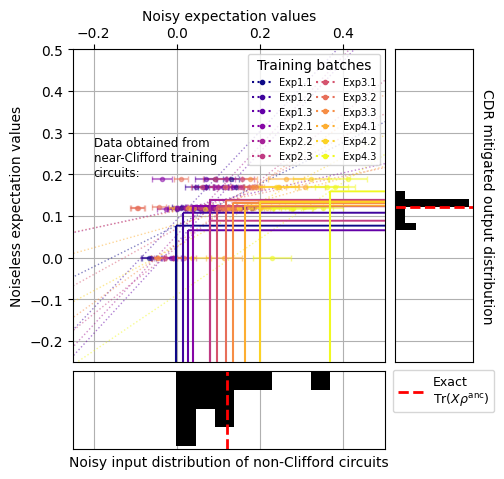

In [6]:
index = 2
mask = clifford_masks[index]
step = str(index+1)

X_noisy = evcdr.results['clifford_data']['X']['noisy'][step][:,mask]
Z_noisy = evcdr.results['clifford_data']['Z']['noisy'][step][:,mask]
X_stdev = evcdr.results['clifford_data']['X']['stdev'][step][:,mask]
Z_stdev = evcdr.results['clifford_data']['Z']['stdev'][step][:,mask]
X_ideal = evcdr.results['clifford_data']['X']['ideal'][step]
Z_ideal = evcdr.results['clifford_data']['Z']['ideal'][step]
X_curve = evcdr.results['clifford_data']['X']['curve'][step]
Z_curve = evcdr.results['clifford_data']['Z']['curve'][step]
X_curve = [X_curve[i] for i in np.where(mask)[0]]
Z_curve = [Z_curve[i] for i in np.where(mask)[0]]

X_standard = evcdr.results['standard_data']['X']['expval'][step][mask]
Z_standard = evcdr.results['standard_data']['Z']['expval'][step][mask]

V = evo_interp_func([_times[index]])[0]
Z_targ = 2*V/(1+V**2)
X_targ = (1-V**2)/(1+V**2)

# Start with a square Figure.
fig = plt.figure(figsize=(5, 5))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(4, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax       = fig.add_subplot(gs[0, 0])
ax_histx = fig.add_subplot(gs[1, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[0, 1], sharey=ax)

xin  = []
xout = []

standard = X_standard
cliff_range = np.linspace(-1.1, 1.1)
print(cliff_range)
for ind,i in enumerate(np.argsort(standard)):
    _z_curve = X_curve[i]
    _z_stdev = X_stdev.T[i]
    _z_noisy = X_noisy.T[i]
    _z_ideal = X_ideal.T[i]
    _z_standard = standard[i]
    xin.append(_z_standard)
    xout.append(_z_curve(_z_standard))
    color = plt.cm.plasma(ind/(len(Z_standard)-1))
    ax.errorbar(_z_noisy, _z_ideal, xerr=_z_stdev, marker='.', color=color, ls='', capsize=2, alpha=0.5)
    ax.plot(cliff_range, _z_curve(cliff_range), ls=':', color=color, lw=1, alpha=0.5)
    ax.vlines(_z_standard, -1, _z_curve(_z_standard), color=color, zorder=10, ls='-')
    arrow_y_loc = _z_curve(_z_standard)
    ax.arrow(_z_standard,arrow_y_loc,1.1-_z_standard,0,width=0.001,
        length_includes_head=True,head_width=0.02,color=color,head_length=0.02, zorder=10
    )

counts, bins = np.histogram(xin,8)
ax_histx.hist(bins[:-1], bins, weights=-counts, color='black')
counts, bins = np.histogram(xout,5)
ax_histy.hist(bins[:-1], bins, weights=counts, color='black', orientation='horizontal')
ax.set_xlim(-0.25,0.5)
ax.set_ylim(-0.25,0.5)

ax.set_ylabel('Noiseless expectation values')
ax.set_xlabel('Noisy expectation values')
ax.xaxis.set_label_position('top') 
ax.tick_params(axis="x", bottom=False, top=True, labelbottom=False, labeltop=True)
ax_histy.yaxis.set_tick_params(labelbottom=False, left=False)
ax_histy.xaxis.set_visible(False)
ax_histx.xaxis.set_tick_params(labelbottom=False, bottom=False)
ax_histx.yaxis.set_visible(False)
ax.grid()
ax_histx.grid()
ax_histy.grid()

ax_histy.axhline(X_targ, color='red', ls='--', lw=2)
ax_histx.axvline(X_targ, color='red', ls='--', lw=2, label='Exact\nTr$(X\\rho^{\\mathrm{anc}})$')
ax_histx.legend(bbox_to_anchor=(1.37,1.1), fontsize=9)
ax_histx.set_xlabel('Noisy input distribution of non-Clifford circuits')
ax_histy.set_ylabel('CDR mitigated output distribution', rotation=-90, labelpad=15)
ax_histy.yaxis.set_label_position('right') 
ax.text(-0.2,0.195,'Data obtained from\nnear-Clifford training\ncircuits:', fontsize=8.5)

xin_X = xin.copy()
xout_X = xout.copy()

for ind,i in enumerate(np.argsort(standard)):
    k=1+ind//3
    l=1+ind%3
    color = plt.cm.plasma(ind/(len(Z_standard)-1))
    ax.plot([],[], marker='.', label=f'Exp{k}.{l}', color=color, ls=':')

ax.legend(ncol=2, loc='upper right', fontsize=7, columnspacing=0.3, title='Training batches')

# fig.legend(ncol=3, loc='lower center', bbox_to_anchor=(0.5,-0.22))
# fig.savefig('plots/21-qubit_CDR_example_X.pdf', dpi=300, bbox_inches='tight', transparent=True)

Text(0, 0.5, 'Probability density')

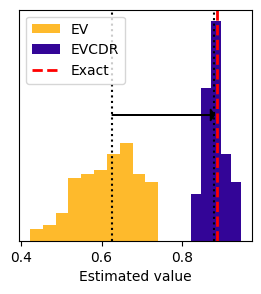

In [7]:
from itertools import product

vals_in = [_z/(1+_x) for _z,_x in product(xin_Z,xin_X)]
vals_out = [_z/(1+_x) for _z,_x in product(xout_Z,xout_X)]

fig, axis = plt.subplots(figsize=(3,3))#figsize=(10,2))
counts, bins = np.histogram(vals_in,10)
axis.hist(bins[:-1], bins, weights=counts, color=plasma0, label='EV')
counts, bins = np.histogram(vals_out,5)
axis.hist(bins[:-1], bins, weights=counts, color=plasma3, label='EVCDR')
axis.axvline(V, color='red', ls='--', lw=2, label='Exact')
axis.axvline(np.median(vals_in), color='black', ls=':')
axis.axvline(np.median(vals_out), color='black', ls=':')
axis.legend(loc='upper left')
axis.arrow(np.median(vals_in), 32, np.median(vals_out)-np.median(vals_in), 0, 
           length_includes_head=True, head_length=0.01, head_width=3, color='black')
# axis.grid(alpha=0.5)
axis.yaxis.set_visible(False)
axis.set_xlabel('Estimated value')# $\\langle V \\rangle$')
axis.set_ylabel('Probability density')
# fig.savefig('plots/21-qubit_CDR_example_final_exp_SMALL.pdf', dpi=300, bbox_inches='tight', transparent=True)

In [8]:
# import json
# import numpy as np
# with open('data/IBM_evidence_comparison/EVCDR_data_compiled.json', 'r') as infile:
#     data_out = json.load(infile)
# # data_out = {}
# data_out["0"] = {
#     'n_qubits':21, 
#     'errors':abs(clifford_interpolated-noiseless_energies).tolist(), 
#     'angles':(_times).tolist(),
#     'nonlocal_depths': list(evcdr.results['circuit_nonlocal_depths'].values()),
#     'total_depths':list(evcdr.results['circuit_depths'].values()),
#     'n_qubits_lightcone':[int(len(qs)/4) for qs in evcdr.results['active_qubits'].values()]
# }
# with open('data/IBM_evidence_comparison/EVCDR_data_compiled.json', 'w') as outfile:
#     json.dump(data_out, outfile)